
# **Review Trees and Boosting including Ada Boosting and XGBoost**  

This section will work with a spam email dataset again. Our ultimate goal is to be able to build models so that we can predict whether an email is spam or not spam based on word characteristics within each email. We will review Decision Trees, Bagging, and Random Forest methods, and introduce Boosting: Ada Boost and XGBoost.

Specifically, we will: 
  
1. Quick review Decision Trees, Bagging, and Random Forest
2. Trees in the context of the bias—variance tradeoff
3. Rebuild the Decision Tree model, Bagging model, Random Forest Model just for comparison with Boosting. 
4. *Theory:* What is Boosting?
5. Use the Adaboost on the Spam Dataset.
6. *Theory:* What is Gradient Boosting and XGBoost?
7. Use XGBoost on the Spam Dataset: Extreme Gradient Boosting

Optional: Example to better understand Bias vs Variance tradeoff.


## Quick review  Decision Trees, Bagging, and Random Forest

### ensemble: a group of items viewed as a whole rather than individually

#### The Idea: Decision Trees are just flowcharts and interpretable!

It turns out that simple flow charts can be formulated as mathematical models for classification and these models have the properties we desire;
 - interpretable by humans 
 - have sufficiently complex decision boundaries 
 - the decision boundaries are locally linear, each component of the decision boundary is simple to describe mathematically. 

#### How to build Decision Trees (the Learning Algorithm in words): 
To learn a decision tree model, we take a greedy approach: 
 1. Start with an empty decision tree (undivided feature space) 
 2. Choose the ‘optimal’ predictor on which to split and choose the ‘optimal’ threshold value for splitting by applying a **splitting criterion (1)**
 3. Recurse on each new node until **stopping condition (2)** is met

#### So we need a (1) splitting criterion and a (2) stopping condition:

  #### Splitting criterion 

While there is no "correct" way to define an optimal split, there are
some common sensical guidelines for every splitting criterion:

- the regions in the feature space should grow progressively more
pure with the number of splits. That is, we should see each region
‘specialize’ towards a single class.

- the fitness metric of a split should take a differentiable form
(making optimization possible).

- we shouldn’t end up with empty regions - regions containing no
training points.

#### Stopping condition

Not stopping while building a deeper and deeper tree = 100% training accuracy; Yet we will overfit!

To prevent the **overfitting** from happening, we should have stopping condition.

-------------

#### How do we go from Classification to Regression?

- For classification, we return the majority class in the points of each leaf node. 
- For regression we return the average of the outputs for the points in each leaf node. 

-------------

#### What is bagging?
  
One way to adjust for the high variance of the output of an experiment is to perform the experiment multiple times and then average the results. 

 1. **Bootstrap:** we generate multiple samples of training data, via bootstrapping. We train a full decision tree on each sample of data. 
 2. **AGgregatiING** for a given input, we output the averaged outputs of all the models for that input. 
 
This method is called **Bagging: B** ootstrap + **AGG**regat**ING**. 

-------------

#### What is Random Forest? 

- **Many trees** make a **forest**.
- **Many random trees** make a **random forest**.


Random Forest is a modified form of bagging that creates ensembles of independent decision trees. 
To *de-correlate the trees*, we: 
1. train each tree on a separate bootstrap **random sample** of the full training set (same as in bagging) 
2. for each tree, at each split, we **randomly select a set of 𝐽′ predictors from the full set of predictors.** (not done in bagging)
3. From amongst the 𝐽′  predictors, we select the optimal predictor and the optimal corresponding threshold for the split. 

-------------

-------------

### Let's talk about decision trees, bagging, and random forest in the context of bias and variance.

#### When is a decision tree underfit? When is a decision tree overfit? Let's think about this in the concept of tree depth.

#### Bagging enjoys the benefits of 
- High expressiveness (by using larger trees it is able to approximate complex functions and decision boundaries).
- Low variance by averaging the prediction of all the models thus reducing the noise in the final prediction.

#### What is the weakness of bagging?
- In practice, the ensemble of trees tends to be highly correlated. If the base models (trees) are biased in a certain direction, bagging them won't help in reducing this bias.
- When could my bagging model be underfit? In what way does this apply to other ensemble methods?


-------------

## Just re-building the tree models

### Rebuild the Decision Tree model, Bagging model and Random Forest Model for comparison with Boosting methods

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import sklearn.metrics as metrics
import time
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
%matplotlib inline

pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

from sklearn.model_selection import learning_curve

In [3]:
#Import Dataframe and Set Column Names
spam_df = pd.read_csv('data/spam.csv', header=None)
columns = ["Column_"+str(i+1) for i in range(spam_df.shape[1]-1)] + ['Spam']
spam_df.columns = columns
display(spam_df.head())

,Column_1,Column_2,Column_3,Column_4,Column_5,Column_6,Column_7,Column_8,Column_9,Column_10,Column_11,Column_12,Column_13,Column_14,Column_15,Column_16,Column_17,Column_18,Column_19,Column_20,Column_21,Column_22,Column_23,Column_24,Column_25,Column_26,Column_27,Column_28,Column_29,Column_30,Column_31,Column_32,Column_33,Column_34,Column_35,Column_36,Column_37,Column_38,Column_39,Column_40,Column_41,Column_42,Column_43,Column_44,Column_45,Column_46,Column_47,Column_48,Column_49,Column_50,Column_51,Column_52,Column_53,Column_54,Column_55,Column_56,Column_57,Spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,0.00,0.64,0.00,0.00,0.00,0.32,0.00,1.29,1.93,0.00,0.96,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,0.21,0.79,0.65,0.21,0.14,0.14,0.07,0.28,3.47,0.00,1.59,0.0,0.43,0.43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.07,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,0.38,0.45,0.12,0.00,1.75,0.06,0.06,1.03,1.36,0.32,0.51,0.0,1.16,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.06,0.0,0.0,0.12,0.0,0.06,0.06,0.0,0.0,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0.00,0.00,0.31,0.00,0.00,3.18,0.00,0.31,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0.00,0.00,0.31,0.00,0.00,3.18,0.00,0.31,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [4]:
#Let us split the dataset into a 70-30 split by using the following:
#Split data into train and test
np.random.seed(42)
msk = np.random.rand(len(spam_df)) < 0.7
data_train = spam_df[msk]
data_test = spam_df[~msk]

#Split predictor and response columns
x_train, y_train = data_train.drop(['Spam'], axis=1), data_train['Spam']
x_test , y_test  = data_test.drop(['Spam'] , axis=1), data_test['Spam']

print("Shape of Training Set :",data_train.shape)
print("Shape of Testing Set :" ,data_test.shape)

Shape of Training Set : (3262, 58)
Shape of Testing Set : (1339, 58)


In [5]:
#Check Percentage of Spam in Train and Test Set
percentage_spam_training = 100*y_train.sum()/len(y_train)
percentage_spam_testing  = 100*y_test.sum()/len(y_test)
                                                  
print("Percentage of Spam in Training Set \t : {:0.2f}%.".format(percentage_spam_training))
print("Percentage of Spam in Testing Set \t : {:0.2f}%.".format(percentage_spam_testing))

Percentage of Spam in Training Set 	 : 39.18%.
Percentage of Spam in Testing Set 	 : 39.96%.


### Fitting an Optimal Single Decision Tree

In [6]:
# Best depth for single decision trees of last week
best_depth = 7
print("The best depth was found to be:", best_depth)

The best depth was found to be: 7


In [7]:
#Evalaute the performance at the best depth
model_tree = DecisionTreeClassifier(max_depth=best_depth)
model_tree.fit(x_train, y_train)

#Check Accuracy of Spam Detection in Train and Test Set
acc_trees_training = accuracy_score(y_train, model_tree.predict(x_train))
acc_trees_testing  = accuracy_score(y_test,  model_tree.predict(x_test))

print("Simple Decision Trees: Accuracy, Training Set \t : {:.2%}".format(acc_trees_training))
print("Simple Decision Trees: Accuracy, Testing Set \t : {:.2%}".format(acc_trees_testing))

Simple Decision Trees: Accuracy, Training Set 	 : 94.39%
Simple Decision Trees: Accuracy, Testing Set 	 : 90.81%


### Fitting 100 Single Decision Trees while Bagging

In [15]:
n_trees = 5 # we tried a variety of numbers here

#Creating model
np.random.seed(0)

# model = DecisionTreeClassifier(max_depth=best_depth+5)

#Initializing variables
predictions_train = np.zeros((data_train.shape[0], n_trees))
predictions_test = np.zeros((data_test.shape[0], n_trees))

#Conduct bootstraping iterations
for i in range(n_trees):
    model = DecisionTreeClassifier(max_depth=best_depth+5)
    temp = data_train.sample(frac=1, replace=True)
    response_variable = temp['Spam']
    temp = temp.drop(['Spam'], axis=1)
    
    model.fit(temp, response_variable)  
    predictions_train[:,i] = model.predict(x_train)   
    predictions_test[:,i] = model.predict(x_test)
    
#Make Predictions Dataframe
columns = ["Bootstrap-Model_"+str(i+1) for i in range(n_trees)]
predictions_train = pd.DataFrame(predictions_train, columns=columns)
predictions_test = pd.DataFrame(predictions_test, columns=columns)

In [16]:
#Function to ensemble the prediction of each bagged decision tree model
def get_prediction(df, count=-1):
    count = df.shape[1] if count==-1 else count
    temp = df.iloc[:,0:count]
    return np.mean(temp, axis=1)>0.5

#Check Accuracy of Spam Detection in Train and Test Set
acc_bagging_training = 100*accuracy_score(y_train, get_prediction(predictions_train, count=-1))
acc_bagging_testing  = 100*accuracy_score(y_test, get_prediction(predictions_test, count=-1))

print("Bagging: \tAccuracy, Training Set \t: {:0.2f}%".format(acc_bagging_training))
print("Bagging: \tAccuracy, Testing Set \t: {:0.2f}%".format( acc_bagging_testing))

Bagging: 	Accuracy, Training Set 	: 97.30%
Bagging: 	Accuracy, Testing Set 	: 93.05%


### Fitting Random Forest

In [9]:
#Fit a Random Forest Model
#Training
model = RandomForestClassifier(n_estimators=n_trees, max_depth=best_depth+5)
model.fit(x_train, y_train)

#Predict
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

#Performance Evaluation
acc_random_forest_training = accuracy_score(y_train, y_pred_train)*100
acc_random_forest_testing = accuracy_score(y_test, y_pred_test)*100

print("Random Forest: Accuracy, Training Set : {:0.2f}%".format(acc_random_forest_training))
print("Random Forest: Accuracy, Testing Set :  {:0.2f}%".format(acc_random_forest_testing))

Random Forest: Accuracy, Training Set : 98.10%
Random Forest: Accuracy, Testing Set :  94.77%


#### Let's compare the performance of our 3 models:

In [10]:
print("Decision Trees:\tAccuracy, Training Set \t: {:.2%}".format(acc_trees_training))
print("Decision Trees:\tAccuracy, Testing Set \t: {:.2%}".format(acc_trees_testing))

print("\nBagging: \tAccuracy, Training Set \t: {:0.2f}%".format(acc_bagging_training))
print("Bagging: \tAccuracy, Testing Set \t: {:0.2f}%".format( acc_bagging_testing))

print("\nRandom Forest: \tAccuracy, Training Set \t: {:0.2f}%".format(acc_random_forest_training))
print("Random Forest: \tAccuracy, Testing Set \t: {:0.2f}%".format(acc_random_forest_testing))

Decision Trees:	Accuracy, Training Set 	: 94.39%
Decision Trees:	Accuracy, Testing Set 	: 90.81%

Bagging: 	Accuracy, Training Set 	: 97.70%
Bagging: 	Accuracy, Testing Set 	: 93.35%

Random Forest: 	Accuracy, Training Set 	: 98.10%
Random Forest: 	Accuracy, Testing Set 	: 94.77%


In [11]:
print(len(model.estimators_[0].tree_.feature))
print(len(model.estimators_[0].tree_.threshold))

295
295


# Exploring RandomForestClassifier class instances.

For more resources on python classes (we're relying on them all the time via sklearn!) see <a href = "https://docs.python.org/3/tutorial/classes.html#a-first-look-at-classes">this link.</a>


In [13]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn import datasets
from sklearn.ensemble import BaggingRegressor
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

def load_cancer_dataset(num_samples=10, random_seed=4):
    """
    Load a subset of the breast cancer dataset from sklearn, scale it, and return it.
    
    Parameters:
    - num_samples (int): Number of samples to select from the dataset.
    - random_seed (int): Random seed for reproducibility.
    
    Returns:
    - tuple: Scaled feature matrix and target vector.
    """
    data = load_breast_cancer()
    X, y = data.data, data.target
    
    # Scale the dataset
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Use random seed for reproducibility
    np.random.seed(random_seed)
    indices = np.random.choice(len(X), num_samples, replace=False)
    return X_scaled[indices], y[indices]

def get_tree_pd(x_train, y_train, model, tree_depth_range):
    """
    Conduct cross-validation for a DecisionTreeClassifier model over different depths.
    
    Parameters:
    - x_train (array-like): Training feature matrix.
    - y_train (array-like): Training target vector.
    - model (DecisionTreeClassifier): Decision Tree model to evaluate.
    - tree_depth_range (range): Range of depths to evaluate the model on.
    
    Returns:
    - DataFrame: Contains the depth and corresponding cross-validation accuracy scores.
    """
    scores_data = {"depth": [], "cv_acc_score": []}
    
    for depth in tree_depth_range:
        model.set_params(max_depth=depth)
        scores = cross_val_score(model, x_train, y_train, cv=5)
        scores_data["depth"].extend([depth] * len(scores))
        scores_data["cv_acc_score"].extend(scores)
    
    return pd.DataFrame(scores_data)


%matplotlib inline

pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

from sklearn.model_selection import learning_curve


cancer_scaled, target = load_cancer_dataset(100, 4)

################################### Train Test split
np.random.seed(40)

#test_proportion
test_prop = 0.2
msk = np.random.uniform(0, 1, len(cancer_scaled)) > test_prop

#Split predictor and response columns
X_train, y_train =  cancer_scaled[msk], target[msk]
X_test , y_test  = cancer_scaled[~msk], target[~msk]

print("Shape of Training Set :", X_train.shape)
print("Shape of Testing Set :" , X_test.shape)

################################### Train a bagging and random forest model

depth = 13
n_estimators = 100
best_rf_model = RandomForestClassifier(max_depth=depth, random_state = 42, n_estimators= n_estimators)
best_rf_model.fit(X_train, y_train.reshape(-1,))
tree_rf_accuracy = best_rf_model.score(X_test, y_test.reshape(-1,))


bagging_model = BaggingRegressor(DecisionTreeClassifier(max_depth=depth), 
                                 n_estimators = 100,
                                 random_state = 42).fit(X_train, y_train.reshape(-1,))

Shape of Training Set : (75, 30)
Shape of Testing Set : (25, 30)


## Directions 
Run the cell below and look at the output. The .estimators_ attribute of a RandomForestClassifier class instance is a list of the individual DecisionTreeClassifier class instance estimators that make up the ensemble model. Calling .tree_ on the DecisionTreeClassifier will give you the individual tree estimator. 
1. Complete the function by extracting the impurity and feature attributes for each decision tree estimator at a specific decision node.
2. Fix the creation of the dictionary at the bottom of the function and return a dataframe.

In [14]:
help(best_rf_model.estimators_[0].tree_)

Help on Tree object:

class Tree(builtins.object)
 |  Array-based representation of a binary decision tree.
 |  
 |  The binary tree is represented as a number of parallel arrays. The i-th
 |  element of each array holds information about the node `i`. Node 0 is the
 |  tree's root. You can find a detailed description of all arrays in
 |  `_tree.pxd`. NOTE: Some of the arrays only apply to either leaves or split
 |  nodes, resp. In this case the values of nodes of the other type are
 |  arbitrary!
 |  
 |  Attributes
 |  ----------
 |  node_count : int
 |      The number of nodes (internal nodes + leaves) in the tree.
 |  
 |  capacity : int
 |      The current capacity (i.e., size) of the arrays, which is at least as
 |      great as `node_count`.
 |  
 |  max_depth : int
 |      The depth of the tree, i.e. the maximum depth of its leaves.
 |  
 |  children_left : array of int, shape [node_count]
 |      children_left[i] holds the node id of the left child of node i.
 |      For leave

In [30]:
# STUDENT TODO
def get_impurity_pd(model, n = 0):
    """
    This function returns a pandas dataframe with all of the nth nodes feature impurities.
    """
    rf_estimators = model.estimators_.copy()
    features = np.array(x_train.columns)
    
    node_impurities, node_features = [], []

    for i, estimator in enumerate(rf_estimators):
        estimator_impurity = #TODO 0 
        estimator_feature  = #TODO 1
        
        node_impurities.append(estimator_impurity)
        node_features.append(estimator_feature)
    node_impurity_dict = {"feature": #TODO 
                        "impurity": #TODO
                         }
    df = #TODO
    return(df)

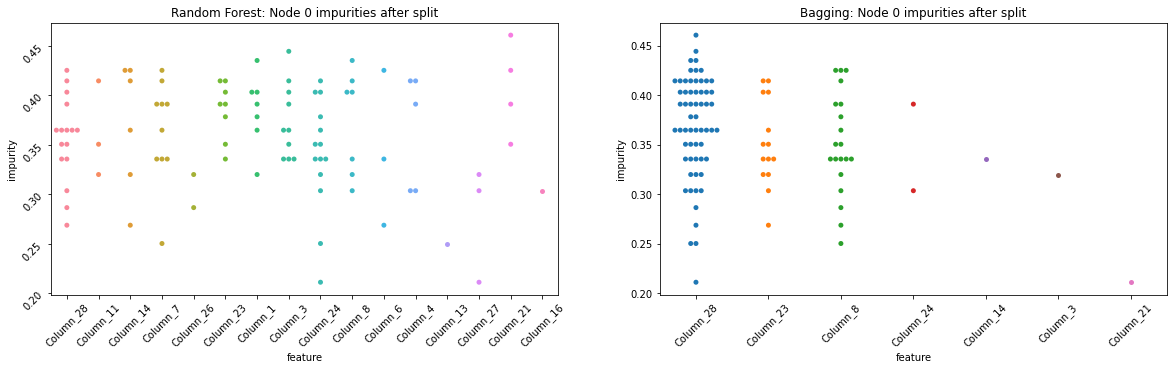

In [31]:
tree_node = 0
rf_df = get_impurity_pd(best_rf_model, tree_node)
bagging_df = get_impurity_pd(bagging_model, tree_node)

#plot
fig, ax = plt.subplots(1,2, figsize = (20, 5))
ax.ravel()

sns.swarmplot(x="feature", y="impurity", data=rf_df, ax=ax[0])
ax[0].tick_params(labelrotation=45)
ax[0].set_title("Random Forest: Node 0 impurities after split")

sns.swarmplot(x="feature", y="impurity", data=bagging_df, ax=ax[1])
ax[1].set_title("Bagging: Node 0 impurities after split")
plt.xticks(rotation=45);

____________

## The limitations of random forest

### When can Random Forest overfit? 
- Increasing the number of trees in RF generally doesn't increase the risk of overfitting, BUT if the number of trees in the ensemble is too large then the trees in the ensemble may become correlated, and therefore increase the variance.

### When can Random Forest fail? 

- **When we have a lot of predictors that are completely independent of the response and one overwhelmingly influential predictor**.

### Why aren't random forests and bagging interpretable?  How about a very deep decision tree?

____________

## Bagging and random forest vs. Boosting

- **Bagging and Random Forest:**
  - complex and deep trees **overfit**
  - thus **let's perform variance reduction on complex trees!**
- **Boosting:** 
  - simple and shallow trees **underfit** 
  - thus **let's perform bias reduction of simple trees!**
  - make the simple trees more expressive!
  
**Boosting** attempts to improve the predictive flexibility of simple models.
 - It trains a **large number of “weak” learners in sequence**.
 - A weak learner is a constrained model (limit the max depth of each decision tree).
 - Each one in the sequence focuses on **learning from the mistakes** of the one before it.
 - By more heavily weighting in the mistakes in the next tree, our next tree will learn from the mistakes.
 - A combining all the weak learners into a single strong learner = **a boosted tree**.

### What is Ada Boost?

- Ada Boost = Adaptive Boosting.
- AdaBoost is adaptive in the sense that subsequent weak learners are tweaked in favor of those instances misclassified by previous classifiers


For an individual training point the loss can be defined as:
$$\text{ExpLoss_i} = \begin{cases}
      e^{\hat{y}}, & \text{if}\ y=-1 \\
      e^{-\hat{y}}, & \text{} y=1
    \end{cases}
$$


## Use the Adaboost method to visualize Bias-Variance tradeoff.

Now let's try Boosting!

In [19]:
#Fit an Adaboost Model

x_train, y_train = data_train.drop(['Spam'], axis=1), data_train['Spam']
x_test , y_test  = data_test.drop(['Spam'] , axis=1), data_test['Spam']

#Training
model = AdaBoostClassifier(base_estimator= DecisionTreeClassifier(max_depth=3), 
                           n_estimators=200, 
                           learning_rate=0.05)
model.fit(x_train, y_train)

#Predict
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

#Performance Evaluation
acc_boosting_training = accuracy_score(y_train, y_pred_train)*100
acc_boosting_test = accuracy_score(y_test, y_pred_test)*100

print("Ada Boost:\tAccuracy, Training Set \t: {:0.2f}%".format(acc_boosting_training))
print("Ada Boost:\tAccuracy, Testing Set \t: {:0.2f}%".format(acc_boosting_test))

d:\code\env\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Ada Boost:	Accuracy, Training Set 	: 98.10%
Ada Boost:	Accuracy, Testing Set 	: 94.40%


**How does the test and training accuracy evolve with every iteration (tree)?**

d:\code\env\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
d:\code\env\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
d:\code\env\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
d:\code\env\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


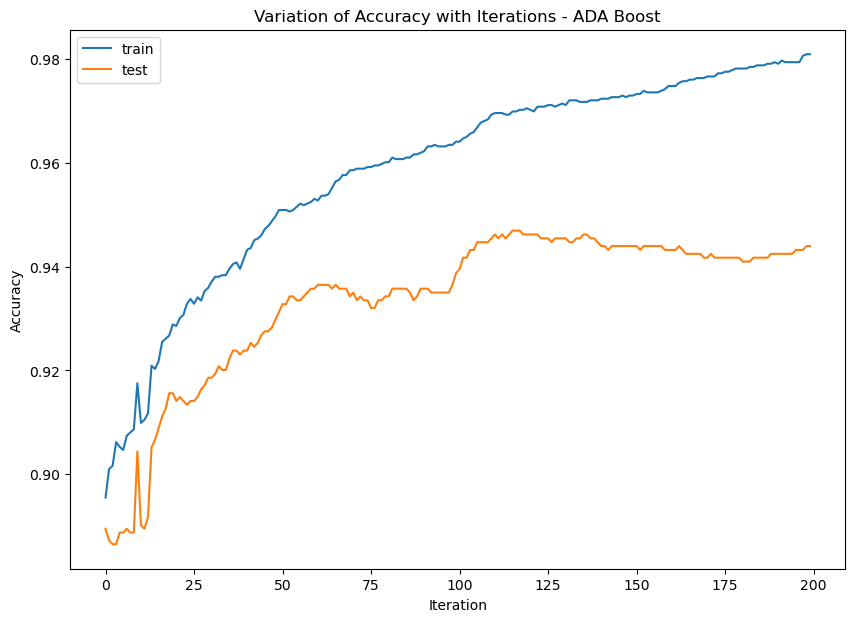

In [20]:
#Plot Iteration based score
train_scores = list(model.staged_score(x_train,y_train))
test_scores = list(model.staged_score(x_test, y_test))

plt.figure(figsize=(10,7))
plt.plot(train_scores,label='train')
plt.plot(test_scores,label='test')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title("Variation of Accuracy with Iterations - ADA Boost")
plt.legend();

What about performance?

In [34]:
print("Decision Trees:\tAccuracy, Testing Set \t: {:.2%}".format(acc_trees_testing))
print("Bagging: \tAccuracy, Testing Set \t: {:0.2f}%".format( acc_bagging_testing))
print("Random Forest: \tAccuracy, Testing Set \t: {:0.2f}%".format(acc_random_forest_testing))
print("Ada Boost:\tAccuracy, Testing Set \t: {:0.2f}%".format(acc_boosting_test))

Decision Trees:	Accuracy, Testing Set 	: 90.81%
Bagging: 	Accuracy, Testing Set 	: 93.35%
Random Forest: 	Accuracy, Testing Set 	: 94.77%
Ada Boost:	Accuracy, Testing Set 	: 94.47%


AdaBoost seems to be performing better than Simple Decision Trees and has a similar Test Set Accuracy performance compared to Random Forest.

**Random tip:** If a "for"-loop takes som time and you want to know the progress while running the loop, use: **tqdm()** ([link](https://github.com/tqdm/tqdm)). No need for 1000's of ```print(i)``` outputs.


Usage: ```for i in tqdm( range(start,finish) ):```

 - tqdm means *"progress"* in Arabic (taqadum, تقدّم) and 
 - tqdm is an abbreviation for *"I love you so much"* in Spanish (te quiero demasiado).

### What if we change the depth of our AdaBoost trees?

In [21]:
! pip install tqdm

In [22]:
# Start Timer
start = time.time()


#Find Optimal Depth of trees for Boosting
score_train, score_test, depth_start, depth_end = {}, {}, 2, 30
for i in tqdm(range(depth_start, depth_end, 2)):
    model = AdaBoostClassifier(
        base_estimator=DecisionTreeClassifier(max_depth=i),
        n_estimators=200, learning_rate=0.05)
    model.fit(x_train, y_train)
    score_train[i] = accuracy_score(y_train, model.predict(x_train))
    score_test[i] = accuracy_score(y_test, model.predict(x_test))
    
# Stop Timer
end = time.time()
elapsed_adaboost = end - start

  0%|          | 0/14 [00:00<?, ?it/s]d:\code\env\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
  7%|▋         | 1/14 [00:01<00:19,  1.53s/it]d:\code\env\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
 14%|█▍        | 2/14 [00:04<00:26,  2.18s/it]d:\code\env\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
 21%|██▏       | 3/14 [00:08<00:32,  2.95s/it]d:\code\env\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
 29%|██▊       | 4/14 [00:12<00:37,  3.72s/it]d:\code\env\anacon

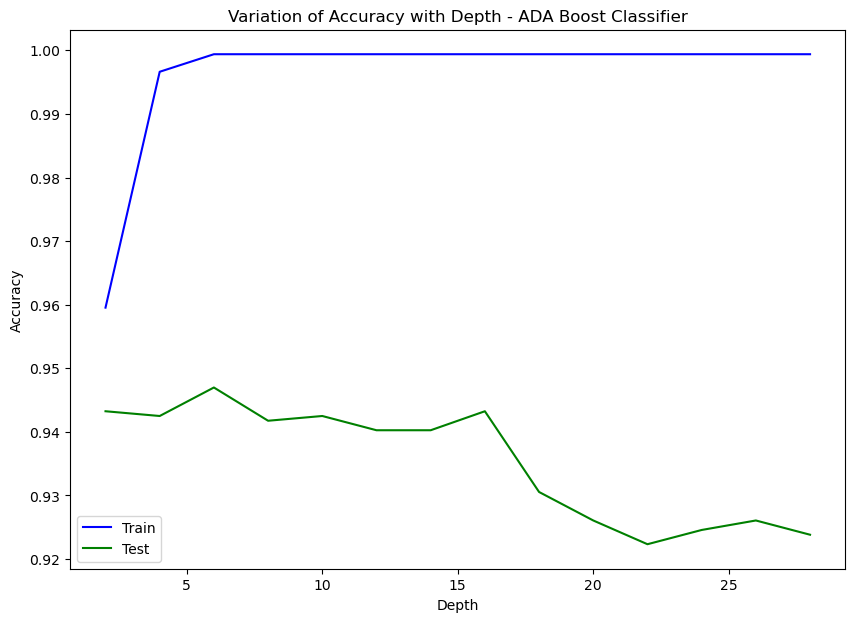

In [23]:
#Plot
lists1 = sorted(score_train.items())
lists2 = sorted(score_test.items())
x1, y1 = zip(*lists1) 
x2, y2 = zip(*lists2) 
plt.figure(figsize=(10,7))
plt.ylabel("Accuracy")
plt.xlabel("Depth")
plt.title('Variation of Accuracy with Depth - ADA Boost Classifier')
plt.plot(x1, y1, 'b-', label='Train')
plt.plot(x2, y2, 'g-', label='Test')
plt.legend()
plt.show()

Adaboost complexity depends on both the number of estimators and the base estimator. 
- In the beginning as our model complexity increases (depth 2-3), we first observe a small increase in accuracy.
- But as we go further to the right of the graph (**deeper trees**), our model **will overfit the data.**
- **REMINDER and validation: Boosting relies on simple trees!**

# Explore how changing the learning rate changes the training and testing accuracy. Use the Te Quero Demasiado (TQDM) wrap around your range as above. (Hint you will probably want to explore a range from $e^{-6}$ to $e^{-1}$

In [28]:
#TODO
# Start Timer
start = time.time()

num = 20
#Find Optimal Depth of trees for Boosting
score_train, score_test, depth_start, depth_end = {}, {}, 0.000001, 0.0001
for i in tqdm([depth_start + ((depth_end-depth_start) / num) * i for i in range(num) ]):
    model = AdaBoostClassifier(
        base_estimator=DecisionTreeClassifier(max_depth=10),
        n_estimators=200, learning_rate=i)
    model.fit(x_train, y_train)
    score_train[i] = accuracy_score(y_train, model.predict(x_train))
    score_test[i] = accuracy_score(y_test, model.predict(x_test))
    
# Stop Timer
end = time.time()
elapsed_adaboost = end - start

  0%|          | 0/20 [00:00<?, ?it/s]d:\code\env\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
  5%|▌         | 1/20 [00:05<01:49,  5.75s/it]d:\code\env\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
 10%|█         | 2/20 [00:11<01:43,  5.74s/it]d:\code\env\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
 15%|█▌        | 3/20 [00:17<01:39,  5.87s/it]d:\code\env\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
 20%|██        | 4/20 [00:23<01:34,  5.88s/it]d:\code\env\anacon

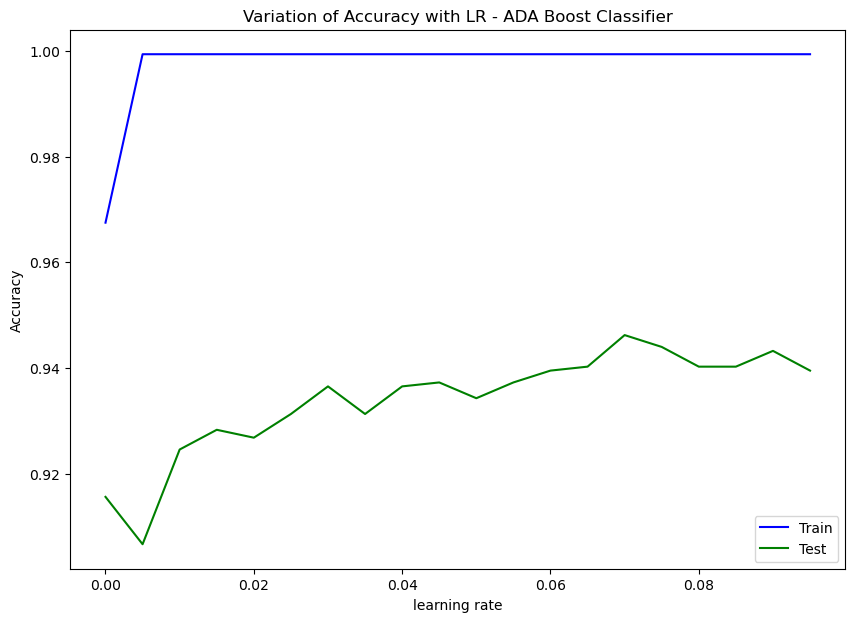

In [27]:
#Plot
lists1 = sorted(score_train.items())
lists2 = sorted(score_test.items())
x1, y1 = zip(*lists1) 
x2, y2 = zip(*lists2) 
plt.figure(figsize=(10,7))
plt.ylabel("Accuracy")
plt.xlabel("learning rate")
plt.title('Variation of Accuracy with LR - ADA Boost Classifier')
plt.plot(x1, y1, 'b-', label='Train')
plt.plot(x2, y2, 'g-', label='Test')
plt.legend()
plt.show()

## Is this exercise useful?

**Food for Thought :**
- Are **boosted models independent of one another?** Do they need to wait for the previous model's residuals?
- Are **bagging or random forest models independent of each other**, can they be trained in a parallel fashion?

## *Theory:* What is Gradient Boosting and XGBoost?

### What is Gradient Boosting?

To improve its predictions, **gradient boosting looks at the difference between its current approximation, and the known correct target vector, which is called the residual**.

The mathematics:

- It may be assumed that there is some imperfect model $F_{m}$ 
- The gradient boosting algorithm improves on $F_{m}$ constructing a new model that adds an estimator $h$ to provide a better model: 
$$F_{m+1}(x)=F_{m}(x)+h(x)$$

- To find $h$, the gradient boosting solution starts with the observation that a perfect **h** would imply

$$F_{m+1}(x)=F_{m}(x)+h(x)=y$$

- or, equivalently solving for h,

$$h(x)=y-F_{m}(x)$$

- Therefore, gradient boosting will fit h to the residual $y-F_{m}(x)$


-------

### XGBoost: ["Long May She Reign!"](https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d)




----------

### What is XGBoost and why is it so good!?
 - Based on Gradient Boosting
 - XGBoost = **eXtreme Gradient Boosting**; refers to the engineering goal to push the limit of computations resources for boosted tree algorithm
 
**Accuracy:**
 - XGBoost however uses a **more regularized model formalizaiton to control overfitting** (=better performance) by both L1 and L2 regularization.
 - Tree Pruning methods: more shallow tree will also prevent overfitting
 - Improved convergence techniques (like early stopping when no improvement is made for X number of iterations)
 - Built-in Cross-Validaiton
 
**Computing Speed:**
 - Special Vector and matrix type data structures for faster results.
 - Parallelized tree building: using all of your CPU cores during training.
 - Distributed Computing: for training very large models using a cluster of machines.
 - Cache Optimization of data structures and algorithm: to make best use of hardware.

**XGBoost is building boosted trees in parallel? What? How?**
- No: Xgboost doesn't run multiple trees in parallel, you need predictions after each tree to update gradients.
- Rather it does the parallelization WITHIN a single tree my using openMP to create branches independently.

## Use XGBoost: Extreme Gradient Boosting

In [30]:
# Let's install XGBoost
! pip install xgboost

     ---------------------------------------- 99.7/99.7 MB 3.7 MB/s eta 0:00:00


In [32]:
import xgboost as xgb

# Create the training and test data
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

# Parameters
param = {
    'max_depth': best_depth,  # the maximum depth of each tree
    'eta': 0.3,               # the training step for each iteration
    'silent': 1,              # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 2}           # the number of classes that exist in this datset

# Number of training iterations
num_round = 200  

# Start timer
start = time.time()

# Train XGBoost
bst = xgb.train(param, 
                dtrain, 
                num_round, 
                evals= [(dtrain, 'train')], 
                early_stopping_rounds=20, # early stopping
                verbose_eval=20)


# Make prediction training set
preds_train = bst.predict(dtrain)
best_preds_train = np.asarray([np.argmax(line) for line in preds_train])

# Make prediction test set
preds_test = bst.predict(dtest)
best_preds_test = np.asarray([np.argmax(line) for line in preds_test])

# Performance Evaluation 
acc_XGBoost_training = accuracy_score(y_train, best_preds_train)*100
acc_XGBoost_test = accuracy_score(y_test, best_preds_test)*100

# Stop Timer
end = time.time()
elapsed_xgboost = end - start

print("XGBoost:\tAccuracy, Training Set \t: {:0.2f}%".format(acc_XGBoost_training))
print("XGBoost:\tAccuracy, Testing Set \t: {:0.2f}%".format(acc_XGBoost_test))

[0]	train-mlogloss:0.49039


[20]	train-mlogloss:0.05598
[40]	train-mlogloss:0.02696


d:\code\env\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [15:32:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[60]	train-mlogloss:0.01646
[80]	train-mlogloss:0.01023
[100]	train-mlogloss:0.00712
[120]	train-mlogloss:0.00548
[140]	train-mlogloss:0.00448
[160]	train-mlogloss:0.00391
[180]	train-mlogloss:0.00351
[199]	train-mlogloss:0.00324
XGBoost:	Accuracy, Training Set 	: 99.94%
XGBoost:	Accuracy, Testing Set 	: 95.00%


### What about the accuracy performance: AdaBoost versus XGBoost?

In [41]:
print("Ada Boost:\tAccuracy, Testing Set \t: {:0.2f}%".format(acc_boosting_test))
print("XGBoost:\tAccuracy, Testing Set \t: {:0.2f}%".format(acc_XGBoost_test))

Ada Boost:	Accuracy, Testing Set 	: 94.47%
XGBoost:	Accuracy, Testing Set 	: 95.00%


### What about the computing performance: AdaBoost versus XGBoost?

In [42]:
print("AdaBoost elapsed time: \t{:0.2f}s".format(elapsed_adaboost))
print("XGBoost elapsed time: \t{:0.2f}s".format(elapsed_xgboost))

AdaBoost elapsed time: 	80.55s
XGBoost elapsed time: 	1.60s


### What if we change the depth of our XGBoost trees and compare to Ada Boost?

In [48]:
def model_xgboost(best_depth):
    param = {
    'max_depth': best_depth,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'verbosity': 0,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 2}  # the number of classes that exist in this datset

    # the number of training iterations
    num_round = 200  

    bst = xgb.train(param, 
                    dtrain, 
                    num_round, 
                    evals= [(dtrain, 'train')], 
                    early_stopping_rounds=20,
                    verbose_eval=False)

    preds_train = bst.predict(dtrain)
    best_preds_train = np.asarray([np.argmax(line) for line in preds_train])
    preds_test = bst.predict(dtest)
    best_preds_test = np.asarray([np.argmax(line) for line in preds_test])

    #Performance Evaluation
    XGBoost_training = accuracy_score(y_train, best_preds_train)
    XGBoost_test = accuracy_score(y_test, best_preds_test)
    
    return XGBoost_training, XGBoost_test

In [50]:
#Find Optimal Depth of trees for Boosting
from tqdm import trange

score_train_xgb, score_test_xgb = {}, {}
depth_start, depth_end = 2, 30
for i in trange(depth_start, depth_end, 2):
    XGBoost_training, XGBoost_test = model_xgboost(i)
    score_train_xgb[i] = XGBoost_training
    score_test_xgb[i] = XGBoost_test

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:21<00:00,  1.53s/it]


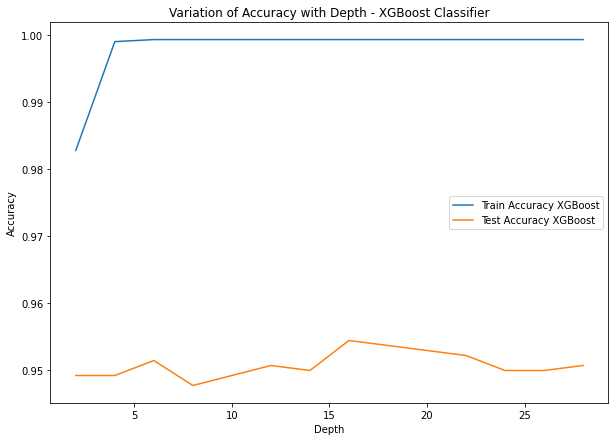

In [54]:
#Plot
lists1 = sorted(score_train_xgb.items())
lists2 = sorted(score_test_xgb.items())
x3, y3 = zip(*lists1) 
x4, y4 = zip(*lists2) 
plt.figure(figsize=(10,7))
plt.ylabel("Accuracy")
plt.xlabel("Depth")
plt.title('Variation of Accuracy with Depth - XGBoost Classifier')
plt.plot(x3, y3, label='Train Accuracy XGBoost')
plt.plot(x4, y4, label='Test Accuracy XGBoost')
plt.legend()
plt.show()

**Interesting**: 
- No real optimal depth of the simple tree for XGBoost, probably a lot of regularization, pruning, or early stopping when using a deep tree at the start.
- XGBoost does not seem to overfit when the depth of the tree increases, as opposed to Ada Boost.

**All the accuracy performances:**

In [55]:
print("Decision Trees:\tAccuracy, Testing Set \t: {:.2%}".format(acc_trees_testing))
print("Bagging: \tAccuracy, Testing Set \t: {:0.2f}%".format( acc_bagging_testing))
print("Random Forest: \tAccuracy, Testing Set \t: {:0.2f}%".format(acc_random_forest_testing))
print("Ada Boost:\tAccuracy, Testing Set \t: {:0.2f}%".format(acc_boosting_test))
print("XGBoost:\tAccuracy, Testing Set \t: {:0.2f}%".format(acc_XGBoost_test))

Decision Trees:	Accuracy, Testing Set 	: 90.81%
Bagging: 	Accuracy, Testing Set 	: 93.35%
Random Forest: 	Accuracy, Testing Set 	: 94.77%
Ada Boost:	Accuracy, Testing Set 	: 94.47%
XGBoost:	Accuracy, Testing Set 	: 95.00%



----------

**Overview of all the tree algorithms:** [Source](https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d)






----------

## Optional: Example to better understand Bias vs Variance tradeoff.

A fundamental concept we've explored is the balance between overfitting and underfitting. As we improved accuracy on the training set, we observed that the model didn't necessarily perform well on unseen data.

As a different example, in face recognition algorithms, such as that on the iPhone X, a too-accurate model would be unable to identity someone who styled their hair differently that day. The reason is that our model may learn irrelevant features in the training data. On the contrary, an insufficiently trained model would not generalize well either. For example, it was recently reported that a face mask could sufficiently fool the iPhone X.

A widely used solution in statistics to reduce overfitting consists of adding structure to the model, with something like regularization. This method favors simpler models during training.

The bias-variance dilemma is closely related. 
- The **bias** of a model quantifies how precise a model is across training sets. 
- The **variance** quantifies how sensitive the model is to small changes in the training set. 
- A **robust** model is not overly sensitive to small changes. 
- **The dilemma involves minimizing both bias and variance**; we want a precise and robust model. Simpler models tend to be less accurate but more robust. Complex models tend to be more accurate but less robust.

**How to reduce bias:**
 - **Use more complex models, more features, less regularization,** ...
 - **Boosting:** attempts to improve the predictive flexibility of simple models. Boosting uses simple base models and tries to “boost” their aggregate complexity.
 
**How to reduce variance:**
 - **Early Stopping:** Its rules provide us with guidance as to how many iterations can be run before the learner begins to over-fit.
 - **Pruning:** Pruning is extensively used while building related models. It simply removes the nodes which add little predictive power for the problem in hand.
 - **Regularization:** It introduces a cost term for bringing in more features with the objective function. Hence it tries to push the coefficients for many variables to zero and hence reduce cost term.
 - **Train with more data:** It won’t work every time, but training with more data can help algorithms detect the signal better.
 - **Ensembling:** Ensembles are machine learning methods for combining predictions from multiple separate models. For example:
   - **Bagging** attempts to reduce the chance of overfitting complex models: Bagging uses complex base models and tries to “smooth out” their predictions.

-------------

### Interesting Piazza post: why randomness in simple decision tree?
 
 ```"Hi there. I notice that there is a parameter called "random_state" in decision tree function and I wonder why we need randomness in simple decision tree. If we add randomness in such case, isn't it the same as random forest?"```
 
  - The problem of learning an optimal decision tree is known to be **NP-complete** under several aspects of optimality and even for simple concepts. 
  - Consequently, practical decision-tree learning algorithms are based on **heuristic algorithms such as the greedy algorithm where locally optimal decisions are made at each node**. 
  - Such algorithms **cannot guarantee to return the globally optimal decision tree**. 
  - This can be mitigated by training multiple trees in an ensemble learner, where the features and samples are randomly sampled with replacement (Bagging).
  
For example: **What is the defaulth DecisionTreeClassifier behaviour when there are 2 or more best features for a certain split (a tie among "splitters")?** (after a deep dive and internet search [link](https://github.com/scikit-learn/scikit-learn/issues/12259 ) ):

  - The current default behaviour when splitter="best" is to shuffle the features at each step and take the best feature to split. 
  - In case there is a tie, we take a random one.